## Quantization Aware Training

This code file demonstrates the implementation of Quantization Aware Training, a critical technique for optimizing machine learning models, specifically for deployment on resource-constrained devices. It explores the following key components and concepts:

1. **Quantization Aware Training**: This technique prepares machine learning models for quantization, a process of reducing the precision of model weights and activations to save memory and improve inference speed on edge devices.

2. **TensorFlow Model Optimization (tfmot)**: The code uses the TensorFlow Model Optimization library to perform quantization-aware training.

3. **Learning Layer Model**: A base neural network model with convolutional and dense layers. Quantization-aware layers are applied to this model during training.

4. **Quantization-Aware Learning Layer**: The learning layer model is quantized using the `quantize_model` function from tfmot. This is a crucial step in the quantization-aware training process.

5. **Quantized Model (Model)**: A final quantized model, including preprocessing and quantization-aware layers. This model is ready for deployment on resource-constrained devices.

6. **Backbone Model**: A pre-trained EfficientNetB5 model with quantization-aware layers applied. It is used as a feature extractor, and its weights are frozen.

7. **TensorLite Conversion**: The code demonstrates how to convert the quantized model to TensorFlow Lite format, which is suitable for mobile and edge device deployment.

8. **Interpreter and Testing**: An interpreter for the TensorFlow Lite model is created, and the code shows how to perform inference using this model.

9. **Convolutional Layer Quantization Annotation**: A function is defined to apply quantization to convolutional layers of the model.

In [2]:
pip install albumentations seaborn wandb onnxruntime tf2onnx tensorflow_model_optimization


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -q kaggle

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! chmod 600 /root/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

human-emotions-datasethes.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.

  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  

  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  

  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  

  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  

  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  

  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  

  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  

  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  

  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  

  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  

  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  

  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  

  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  

  inflating: /content/dataset/EmotionsD

In [4]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model

from tensorflow.keras.layers import (
    Normalization, Dense, InputLayer, Conv2D, GlobalAveragePooling2D,
    MaxPool2D, Flatten, BatchNormalization, Input, MaxPooling2D,
    Layer, Dropout, RandomFlip, RandomRotation, Permute,
    Resizing, Rescaling, RandomContrast, Activation, Add)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ( Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)

from tensorflow.keras.metrics import (
    SparseTopKCategoricalAccuracy, SparseCategoricalAccuracy,
    BinaryAccuracy, Accuracy, Precision, Recall, TruePositives,
    TrueNegatives, FalsePositives, FalseNegatives, AUC,
    CategoricalCrossentropy, SparseCategoricalCrossentropy,
    CategoricalAccuracy, TopKCategoricalAccuracy)


from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.image import flip_up_down, flip_left_right
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from tensorboard.plugins.hparams import api as hp
import tensorflow_probability as tfp
import albumentations as A
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.graph_objs as ff
# import plotly.graph_objects as go
import numpy as np
import datetime
import cv2 as cv
from sklearn.metrics import confusion_matrix, roc_curve
import time
import tf2onnx
import onnxruntime as rt
import pandas as pd
import random


In [5]:
train_dir = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
test_dir = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
class_names = ["angry", "happy", "sad"]

configrations = {"image_size": 256,
                 "batch_size": 32,
                 "learning_rate": 0.001,
                 "n_epochs": 50,
                 "dropout_rate": 0.2,
                 "regularization_rate": 0.0,
                 "n_fliters_1": 128,
                 "n_fliters_2": 64,
                 "kernal_size": 3,
                 "n_strides": 1,
                 "pool_size": 2,
                 "n_dense_1": 256,
                 "n_dense_2": 128,
                 "n_class": 3,
                 "class_names": class_names,
}

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=configrations["batch_size"],
    image_size=(configrations["image_size"], configrations["image_size"]),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [7]:
val_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=configrations["batch_size"],
    image_size=(configrations["image_size"], configrations["image_size"]),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


In [8]:
for item in val_data.take(1):
    print(item)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

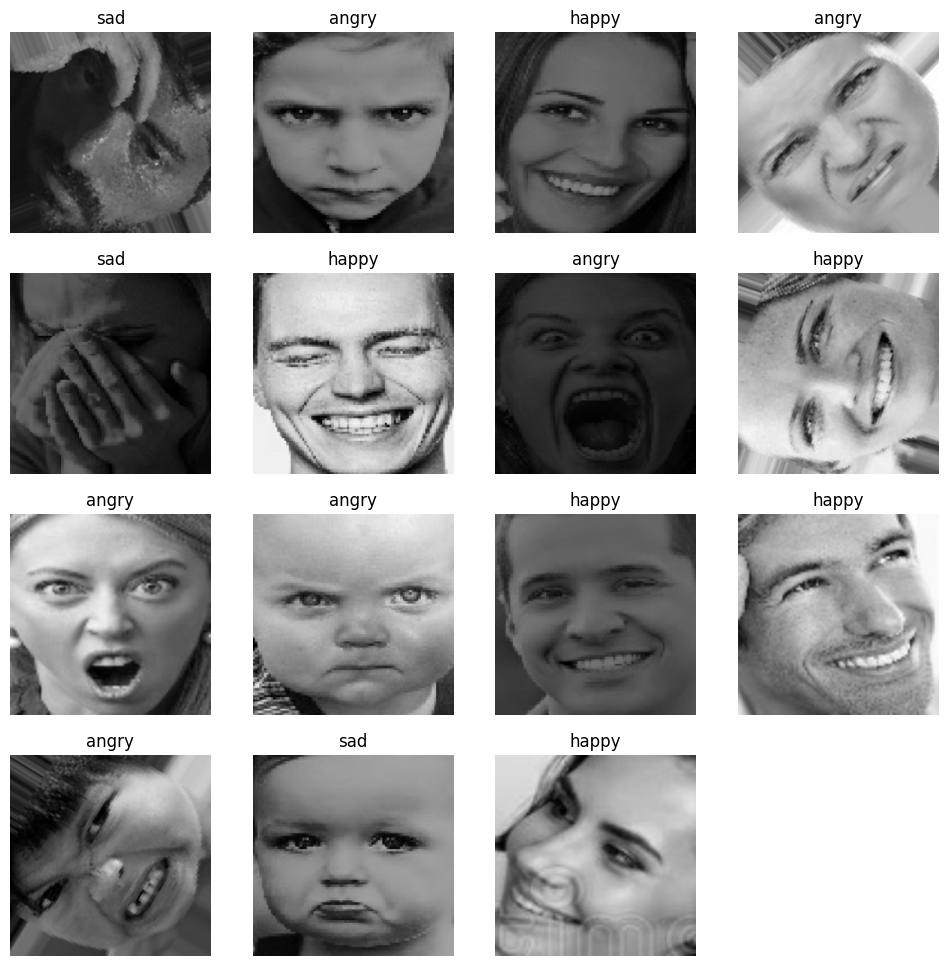

In [9]:
plt.figure(figsize = (12, 12) )

for images, labels in train_data.take(1):
    for i in range(15):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i]/255.0)
        plt.title(class_names[tf.argmax(labels[i], axis=0).numpy()] )  #to show the max number in list
        plt.axis("off")

In [10]:
IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  Resizing(configrations["image_size"], configrations["image_size"]),
  Rescaling(1./255)
])

In [11]:
augent_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025, 0.025)),
    RandomFlip(mode="horizontal"),
    RandomContrast(factor=0.1),

])

In [12]:
def augment_layer(image, label):
    return augent_layers(image, training = True), label

In [13]:
training_data = (
    train_data
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)

)

In [14]:
validation_data = (
    val_data
#     .prefetch(tf.data.AUTOTUNE)

)

## Quantization Aware Training

The code defines a neural network model intended for Quantization Aware Training using TensorFlow/Keras and the TensorFlow Model Optimization Toolkit (`tfmot`).

- `learning_layer_model` is a neural network model.

Here's a breakdown of the components of this model:

1. Input Layer:
   - The model starts with an `InputLayer` specifying the input shape. The shape is determined by `configurations["image_size"]`, indicating images with a size of `(image_size, image_size, 3)` pixels, where `3` represents the number of color channels (typically Red, Green, and Blue for images).

2. Convolutional Layers:
   - The network has two convolutional layers (`Conv2D`) following the input layer. These layers are responsible for feature extraction.
   - The first convolutional layer has parameters such as:
     - Number of filters: `configurations["n_filters_1"]`.
     - Kernel size: `configurations["kernel_size"]`.
     - Strides: `configurations["stride"]`.
     - L2 regularization: The `L2` regularization term with strength defined by `configurations["regularization_rate"]`.
     - Activation function: ReLU (Rectified Linear Unit).
     - Padding: "valid."

3. Flatten Layer:
   - After the convolutional layers, a `Flatten` layer is used to convert the 2D feature maps into a 1D vector. This transformation is necessary for connecting to fully connected layers.

4. Fully Connected (Dense) Layers:
   - Two dense layers follow the flatten layer. These layers perform further feature transformation and classification.
   - Both dense layers have the same specifications:
     - Number of units: `configurations["n_dense_1"]`.
     - Activation function: ReLU.
     - L2 regularization: Regularized with strength `configurations["regularization_rate"]`.

5. Output Layer:
   - The final dense layer has a number of units equal to `configurations["n_class"]`, indicating it is designed for a classification task.
   - The activation function for this output layer is softmax, which is commonly used for multiclass classification tasks.

This neural network model is suited for image classification tasks and is configured for quantization-aware training, a technique used to optimize models for deployment on resource-constrained devices.

Please let me know if you have any further questions or need additional information about this code.


In [15]:
import tensorflow_model_optimization as tfmot

In [16]:
learning_layer_model = tf.keras.Sequential([
    InputLayer(input_shape=(configrations["image_size"], configrations["image_size"], 3)),

#     resize_and_rescale,

    Conv2D(filters=configrations["n_fliters_1"], kernel_size=configrations["kernal_size"], strides=configrations["n_strides"],
           kernel_regularizer=L2(configrations["regularization_rate"]), padding="valid", activation="relu"),
#     BatchNormalization(),
#     MaxPool2D(pool_size=configrations["pool_size"], strides=configrations["n_strides"]),

    Conv2D(filters=configrations["n_fliters_2"], kernel_size=configrations["kernal_size"], strides=configrations["n_strides"],
           kernel_regularizer=L2(configrations["regularization_rate"]), padding="valid", activation="relu"),
#     BatchNormalization(),
#     MaxPool2D(pool_size=configrations["pool_size"], strides=configrations["n_strides"]),

    Flatten(),

    Dense(configrations["n_dense_1"], activation="relu",
          kernel_regularizer=L2(configrations["regularization_rate"]) ),
#     BatchNormalization(),
#     Dropout(rate=configrations["dropout_rate"]),

    Dense(configrations["n_dense_1"], activation="relu",
    kernel_regularizer=L2(configrations["regularization_rate"]) ),
#     BatchNormalization(),

    Dense(configrations["n_class"], activation="softmax")
])

In [17]:
quant_aware_larning_layer = tfmot.quantization.keras.quantize_model(learning_layer_model)

In [18]:
quant_aware_larning_layer.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 256, 256, 3)      3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 254, 254, 128)    3843      
 erV2)                                                           
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 252, 252, 64)     73923     
 pperV2)                                                         
                                                                 
 quant_flatten (QuantizeWrap  (None, 4064256)          1         
 perV2)                                                          
                                                                 
 quant_dense (QuantizeWrappe  (None, 256)             

In [19]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),

    resize_and_rescale,

    Conv2D(filters=configrations["n_fliters_1"], kernel_size=configrations["kernal_size"], strides=configrations["n_strides"],
           kernel_regularizer=L2(configrations["regularization_rate"]), padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=configrations["pool_size"], strides=configrations["n_strides"]),

    Conv2D(filters=configrations["n_fliters_2"], kernel_size=configrations["kernal_size"], strides=configrations["n_strides"],
           kernel_regularizer=L2(configrations["regularization_rate"]), padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=configrations["pool_size"], strides=configrations["n_strides"]),

    Flatten(),

    Dense(configrations["n_dense_1"], activation="relu",
          kernel_regularizer=L2(configrations["regularization_rate"]) ),
    BatchNormalization(),
    Dropout(rate=configrations["dropout_rate"]),

    Dense(configrations["n_dense_1"], activation="relu",
    kernel_regularizer=L2(configrations["regularization_rate"]) ),
    BatchNormalization(),

    Dense(configrations["n_class"], activation="softmax")
])

The code defines a neural network model based on the EfficientNetB5 architecture and performs transfer learning for a specific task. The EfficientNetB5 model is pre-trained on the ImageNet dataset and is fine-tuned for the task at hand.

Here's a breakdown of the code:

1. **Backbone Model:**
   - `backbone` is an instance of the EfficientNetB5 model from TensorFlow/Keras's applications module.
   - `include_top=False` means that the final fully connected layers of the pre-trained model (top layers) are not included.
   - `weights='imagenet'` specifies that the model should be initialized with weights pre-trained on the ImageNet dataset.
   - `input_shape` defines the expected input shape for the model, which is determined by `configurations["image_size"]` and set to `(image_size, image_size, 3)`, where `3` represents the number of color channels (RGB) in the input images.
   - `backbone.trainable = False` freezes the weights of the pre-trained EfficientNetB5 model. This means that the pre-trained layers will not be updated during training for the specific task.

2. **Additional Layers:**
   - `x` receives the output of the `backbone` model. This output represents the features extracted by the EfficientNetB5 model.
   - `GlobalAveragePooling2D()` is applied to reduce the spatial dimensions of the feature maps and compute the average value for each feature map. This results in a fixed-size feature vector.
   - Two fully connected (`Dense`) layers follow, transforming the features:
     - The first dense layer has `configurations["n_dense_1"]` units and uses ReLU activation.
     - The second dense layer has `configurations["n_dense_2"]` units and uses ReLU activation.
   - The final dense layer, `func_output`, consists of `configurations["n_class"]` units with softmax activation, suitable for multi-class classification.

3. **Pre-Trained Model:**
   - `pre_trained` is an instance of the `Model` class, which represents the entire model. It takes the inputs from the `backbone` model and produces the `func_output` as its output.
   - `Model` allows combining different layers into a single model for end-to-end training and inference.

4. **Summary:**
   - `pre_trained.summary()` is used to display a summary of the model architecture, including layer names, output shapes, and the total number of parameters.

This code defines a transfer learning model where the pre-trained EfficientNetB5 model is used as a feature extractor, and additional layers are added to adapt it for a specific task. It's a common approach in deep learning for leveraging pre-trained models to achieve good performance with relatively little training data.

If you have any specific questions or need further clarification, please feel free to ask.


In [23]:
backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False,
    weights='imagenet',
    input_shape=(configrations["image_size"], configrations["image_size"], 3),

)

backbone.trainable = False

In [24]:
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(configrations["n_dense_1"], activation="relu")(x)
x = Dense(configrations["n_dense_2"], activation="relu")(x)
func_output = Dense(configrations["n_class"], activation="softmax")(x)

pre_trained = Model(backbone.inputs, func_output)

pre_trained.summary()

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            

                                                                                                  

 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['input_1[0][0]']             

                                                                                                  

 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling_1[0][0]']         

 on)                                                                                              

                                                                                                  

 rescaling_2 (Rescaling)     (None, 256, 256, 3)          0         ['normalization

In [25]:
check_point = ModelCheckpoint(
    "/content/qunt_aware_eff.pkl",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

redlr = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    min_lr=1e-5,
    verbose=1
)

es = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1
)


In [26]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="Top_K_Accuracy")]

In [27]:
pre_trained.compile(
    optimizer=Adam(learning_rate=configrations["learning_rate"]),
    loss="categorical_crossentropy", metrics=metrics) # sparse_categorical_crossentropy





# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [28]:
pre_trained.load_weights(r"/content/weight_model.h5")

## Applying Quantization to Convolutional Layers

In this section of the code, the focus is on applying quantization to convolutional layers using TensorFlow Model Optimization (tfmot). This technique helps optimize the model for deployment on resource-constrained devices.

### Function `apply_quantization_to_conv_layers`

The function `apply_quantization_to_conv_layers` is defined to selectively annotate (quantize) convolutional layers. It operates as follows:

- For each layer passed to the function, it checks if the layer's name contains the substring "conv." This is a common naming convention for convolutional layers in neural network architectures.

- If the layer's name contains "conv," the function applies quantization to the layer using `tfmot.quantization.keras.quantize_annotate_layer(layer)`.

- If the layer's name doesn't contain "conv," it returns the layer unchanged.

### Creating a Quantization-Aware Model

The variable `qunt_aware_eff` is defined as a new model. It is created by cloning a pre-trained model (`pre_trained`) and applying quantization to its convolutional layers. The `tf.keras.models.clone_model` function is used for this purpose.

- `pre_trained` is the pre-existing model that incorporates the EfficientNetB5 backbone with additional layers.

- The `clone_function` parameter is set to `apply_quantization_to_conv_layers`. This means that the `apply_quantization_to_conv_layers` function is used to quantize (annotate) the convolutional layers during the cloning process.

In summary, this code segment demonstrates the application of quantization to convolutional layers within a pre-trained model, resulting in a new quantization-aware model (`qunt_aware_eff`). This is a crucial step in optimizing the model for efficient deployment on devices with limited computational resources.

Quantization-aware training is essential for improving the model's compatibility with hardware acceleration during inference, making it suitable for edge and embedded devices.


In [29]:
def apply_quantization_to_conv_layers(layer):
    if "conv" in layer.name:
        return tfmot.quantization.keras.quantize_annotate_layer(layer)

    return layer

In [30]:
qunt_aware_eff = tf.keras.models.clone_model(

    pre_trained, clone_function=apply_quantization_to_conv_layers

)

In [31]:
qunt_aware_eff.summary()

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            

                                                                                                  

 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['input_1[0][0]']             

                                                                                                  

 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling_1[1][0]']         

 on)                                                                                              

                                                                                                  

 rescaling_2 (Rescaling)     (None, 256, 256, 3)          0         ['normalization

In [34]:
qunt_aware_eff.compile(
    optimizer = Adam(learning_rate=5e-5),
    loss = loss_function,
    metrics = metrics
)

In [35]:
pre_trained.load_weights(r"/content/weight_model.h5")

In [50]:
pre_trained.evaluate(validation_data)

72/72 [==============================] - 33s 278ms/step - loss: 0.4683 - accuracy: 0.8622 - Top_K_Accuracy: 0.9627


[0.46829280257225037, 0.862159788608551, 0.9626865386962891]

## TensorLite

## Converting the Model to TensorFlow Lite with Representative Data

In this section, the code focuses on converting a pre-trained model (`pre_trained`) to TensorFlow Lite (TFLite), a format optimized for deployment on mobile and embedded devices. Additionally, it includes the use of representative data for quantization during the conversion process.

### Function `representative_data_gen`

The function `representative_data_gen` is defined to generate representative data for quantization. This data is used to ensure that the model's dynamic range is captured accurately, especially when dealing with non-fixed input shapes. In the code:

- The function loops through the `training_data` dataset, taking the first two samples using `training_data.take(2)`.

- For each sample, `input_value` (the model's input) and `j` (not used) are extracted.

- The function yields the `input_value` as a list. Representative data should be provided in the form of a list, even if the model takes multiple inputs.

### Converting to TensorFlow Lite

The conversion to TensorFlow Lite is performed using the `tf.lite.TFLiteConverter`:

- The converter is initialized from the Keras model (`pre_trained`) that you want to convert.

- Optimizations are applied to the converter by setting `converter.optimizations` to `[tf.lite.Optimize.DEFAULT]`. This includes applying default optimizations for the TFLite model, such as quantization.

- The `inference_input_type` and `inference_output_type` are set to `tf.uint8`, indicating that the model will use 8-bit quantization for input and output tensors.

- `converter.representative_dataset` is assigned the `representative_data_gen` function, which provides the representative data for quantization.

- The `converter.convert()` method is called to perform the conversion, resulting in a TensorFlow Lite model (`tflite_model`).

This process converts the original model into a quantized TensorFlow Lite model, which is more suitable for deployment on resource-constrained devices, thanks to its smaller size and optimized inference.

Overall, this code segment demonstrates the critical steps for converting a model to TensorFlow Lite with quantization using representative data, making it well-suited for mobile and edge device applications.


In [36]:
def representative_data_gen():
    for input_value, j in training_data.take(2):
        yield [input_value]

In [37]:
converter = tf.lite.TFLiteConverter.from_keras_model(pre_trained)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

converter.representative_dataset = representative_data_gen

In [38]:
tflite_model = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.

  warnings.warn(


## Saving the TensorFlow Lite Model to a File

In this part of the code, the converted TensorFlow Lite model (`tflite_model`) is being saved to a file. The file will be stored on your filesystem for later use or deployment on edge devices.

### Directory Setup

- `tflite_models_dir` is defined as a pathlib Path object representing the directory where you want to store the TensorFlow Lite models. In this case, it's set to "/content/", which is typically a directory in a Jupyter Notebook environment.

- `tflite_models_dir.mkdir(exist_ok=True, parents=True)` creates the directory specified by `tflite_models_dir`. The `exist_ok=True` argument ensures that the directory is created if it doesn't already exist, and `parents=True` creates any necessary parent directories if they are missing.

### File Path and Write Operation

- `tflite_models_file` is defined as a pathlib Path object representing the full file path for the TensorFlow Lite model file you want to save. It's constructed by appending "eff_model.tflite" to the `tflite_models_dir`.

- `tflite_models_file.write_bytes(tflite_model)` writes the content of the TensorFlow Lite model (`tflite_model`) to the file specified by `tflite_models_file`. This operation effectively saves the model in the TFLite format to the specified file path.

By executing this code, you save the quantized TensorFlow Lite model to the specified directory with the filename "eff_model.tflite." This file can then be used for inference on devices with TensorFlow Lite support.

Overall, this code segment ensures that the converted model is persisted to a file, making it ready for deployment and use in edge or mobile applications.


In [39]:
import pathlib

tflite_models_dir = pathlib.Path("/content/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_models_file = tflite_models_dir / "eff_model.tflite"
tflite_models_file.write_bytes(tflite_model)

32453808

In [42]:
test_image = cv.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/angry/101810.jpg_rotation_1.jpg")
test_image = cv.resize(test_image, (configrations["image_size"], configrations["image_size"]))

test_image = np.expand_dims(test_image, axis=0)


# print(configrations["class_names"][tf.argmax(qunt_aware_eff(im), axis=-1).numpy()[0]])

## Inference with TensorFlow Lite

In this section of the code, you are performing inference using a TensorFlow Lite model (`eff_model.tflite`) on a TensorFlow Lite interpreter.

### Loading the TensorFlow Lite Model

- `interprenter = tf.lite.Interpreter(model_path="/content/eff_model.tflite")` initializes a TensorFlow Lite interpreter using the model located at the specified path. This interpreter is set up to execute inference using the quantized model.

- `interprenter.allocate_tensors()` allocates memory for the model's input and output tensors.

### Accessing Input and Output Details

- `input_details = interprenter.get_input_details()[0]` retrieves details about the model's input tensor. The `[0]` index is used because there might be multiple input tensors, and this code assumes the first one.

- `output_details = interprenter.get_output_details()[0]` retrieves details about the model's output tensor in a similar manner. Again, the `[0]` index is used to access the first output tensor.

### Preparing Input Data

- It appears that there is a comment (`# test_image = im.numpy().astype(input_details["dtype"])`) that suggests you are preparing some input data for inference. However, the code is commented out, and there is no definition for the variable `im`. You may uncomment and provide an actual image or data for inference by converting it to the appropriate data type specified by `input_details["dtype"]`.

### Performing Inference

- `interprenter.set_tensor(input_details["index"], test_image)` sets the input tensor of the TensorFlow Lite model with the prepared input data (`test_image`). Ensure that `test_image` is compatible with the expected data type and shape of the model's input tensor.

- `interprenter.invoke()` executes the inference using the provided input. The model processes the input and produces an output.

- `output = interprenter.get_tensor(output_details["index"])[0]` retrieves the output tensor from the interpreter. It's assumed that this output contains the results of the inference.

By the end of this code segment, the `output` variable holds the results of the inference, which can be used for further analysis or application-specific tasks.

Please ensure that the `test_image` corresponds to the expected input format of the TensorFlow Lite model to obtain meaningful results during inference.


In [43]:
interprenter = tf.lite.Interpreter(model_path="/content/eff_model.tflite")
interprenter.allocate_tensors()

input_details = interprenter.get_input_details()[0]
output_details = interprenter.get_output_details()[0]

# test_image = im.numpy().astype(input_details["dtype"])
interprenter.set_tensor(input_details["index"], test_image)

interprenter.invoke()

output = interprenter.get_tensor(output_details["index"])[0]

In [44]:
print(configrations["class_names"][np.argmax(output, axis=-1)])

angry


## **Accuracy of Quanized Model**

In [47]:
validation_wandb_data = (
    validation_data
    .unbatch()
    .batch(1)
#     .prefetch(tf.data.AUTOTUNE)

)


validation_wandb_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

## Calculating Accuracy with TensorFlow Lite Model

In this section, you have defined a Python function, `accuracy(model_path)`, to compute the accuracy of a TensorFlow Lite model on a validation dataset. The function takes the path to the TensorFlow Lite model as an input.

### Initializing Variables

- `total, correct = 0, 0`: These variables are initialized to keep track of the total number of samples and the number of correctly predicted samples, respectively.

### Loading the TensorFlow Lite Model

- `interprenter = tf.lite.Interpreter(model_path=model_path)` initializes a TensorFlow Lite interpreter using the specified model file located at `model_path`.

- `interprenter.allocate_tensors()` allocates memory for the model's input and output tensors, similar to what was explained in the previous code segment.

### Accessing Input and Output Details

- `input_details = interprenter.get_input_details()[0]` and `output_details = interprenter.get_output_details()[0]` retrieve details about the model's input and output tensors as previously described. These details are needed to configure the interpreter.

### Calculating Accuracy

- The function enters a loop, iterating over a validation dataset (`validation_wandb_data`) for a fixed number of times (20 times in this case, as specified by `.take(20)`). For each validation image (`im`) and its corresponding label (`labels`):

  - `test_image = im.numpy().astype(input_details["dtype"])` converts the image to the appropriate data type specified by the model's input tensor and stores it in `test_image`.

  - `interprenter.set_tensor(input_details["index"], test_image)` sets the input tensor of the TensorFlow Lite model with the processed image data.

  - `interprenter.invoke()` performs inference on the input and produces an output tensor.

  - `output = interprenter.get_tensor(output_details["index"])[0]` retrieves the output tensor, containing the model's predictions.

  - If the model's predicted class (determined by `np.argmax(output)`) matches the actual class label (determined by `np.argmax(labels, axis=-1)[0]`), the `correct` count is incremented. The `total` count is always incremented.

### Returning Accuracy

- The function returns the accuracy as the ratio of `correct` predictions to the `total` number of predictions. This ratio provides an estimate of the model's accuracy on the provided validation dataset.

You can call this function with the path to your TensorFlow Lite model to evaluate its accuracy on a validation dataset and obtain a floating-point accuracy value.


In [48]:
def accuracy(model_path):
    total, correct = 0,0

    interprenter = tf.lite.Interpreter(model_path=model_path)
    interprenter.allocate_tensors()

    input_details = interprenter.get_input_details()[0]
    output_details = interprenter.get_output_details()[0]

    for im, labels in validation_wandb_data.take(20):

        test_image = im.numpy().astype(input_details["dtype"])


        interprenter.set_tensor(input_details["index"], test_image)

        interprenter.invoke()

        output = interprenter.get_tensor(output_details["index"])[0]

        if(int(np.argmax(output)) == int(np.argmax(labels, axis=-1)[0])):
            correct +=1

        total +=1

    return correct/total

In [51]:
accuracy("/content/eff_model.tflite")

0.9